In [1]:
import os
# This line will disable GPU acceleration if desired
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Table of Contents

<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Data import and parsing

In [3]:
import gtar
import numpy as np
import matplotlib, matplotlib.pyplot as pp
import os
import json
import collections
import functools
import itertools
import ipywidgets

import sqlite3
import numpy as np
import io

import flowws
import keras_gtar

def adapt_array(arr):
    """
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())

def convert_array(text):
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)

# Converts np.array to TEXT when inserting
sqlite3.register_adapter(np.ndarray, adapt_array)

# Converts TEXT to np.array when selecting
sqlite3.register_converter("ndarray", convert_array)

from tensorflow.keras.backend import clear_session
import gc
import multiprocessing
from tqdm.notebook import tqdm

class DataSeries:
    def __init__(self):
        self.data = collections.defaultdict(list)

    def add(self, x, y):
        self.data[x].append(y)

    @property
    def x(self):
        return np.array(list(sorted(self.data)))

    @property
    def mean(self):
        return np.array([np.mean(self.data[x], axis=0) for x in self.x])

    @property
    def std(self):
        return np.array([np.std(self.data[x], axis=0) for x in self.x])

    @property
    def stderr(self):
        return np.array([np.std(self.data[x], axis=0)/np.sqrt(len(self.data[x])) for x in self.x])

In [4]:
dbases = []

dbases.append('../data')

conn = sqlite3.connect(":memory:", detect_types=sqlite3.PARSE_DECLTYPES)
conn.execute('create table data '
             '(fname, workflow_description, dataset, model_size, '
             'depth, dropout, score_norm, value_norm, '
             'distance_norm, residual, nonlin, optimizer)')
conn.execute('create table md17 (data_id, molecules)')
conn.execute('create table varyings (data_id, name, arr_value ndarray)')

DATA_NAMES = ['MD17', 'ModelNet', 'PDBCoarseGrained', 'PyriodicDataset', 'RMD17']
DATA_NAME_PREFIXES = []

skipped_list = []

with multiprocessing.Pool() as p:
    for dbase in dbases:
        for (dirpath, dirnames, fnames) in os.walk(dbase, followlinks=True):
            if 'SKIP_THIS_DIR' in fnames:
                continue
            for fname in sorted(fnames):
                fname = os.path.join(dirpath, fname)
                try:
                    with gtar.GTAR(fname, 'r') as traj:
                        dataset = None
                        depth = None
                        model_size = None
                        dropout = None
                        optimizer = None
                        score_norm = None
                        value_norm = None
                        distance_norm = None
                        residual = None
                        nonlin = None
                        molecules = None

                        skip = False

                        m = traj.readStr('workflow.json')

                        if m is None:
                            continue
                        m = json.loads(m)
                        for stage in m['stages']:
                            if (stage['type'] in DATA_NAMES or any(
                                stage['type'].startswith(prefix) for prefix in DATA_NAME_PREFIXES)):
                                dataset = stage['type']
                                molecules = stage['arguments'].get('molecules', None)
                            elif stage['type'] == 'MoleculeForceRegression':
                                depth = stage['arguments']['n_blocks']
                                model_size = stage['arguments']['n_dim']
                                dropout = stage['arguments']['dropout']
                                score_norm = ','.join(stage['arguments']['score_normalization'])
                                value_norm = ','.join(stage['arguments']['value_normalization'])
                                distance_norm = stage['arguments'].get('normalize_distances', '')
                                residual = stage['arguments']['residual']
                                nonlin = stage['arguments']['block_nonlinearity']
                            elif stage['type'].startswith('PDBInverseCoarseGrain'):
                                depth = stage['arguments']['n_blocks_coarse'] + stage['arguments']['n_blocks_fine']
                                model_size = stage['arguments']['n_dim']
                                residual = stage['arguments']['residual']
                                nonlin = stage['arguments']['block_nonlinearity']
                            elif stage['type'] == 'CrystalStructureClassification':
                                depth = stage['arguments']['n_blocks']
                                model_size = stage['arguments']['n_dim']
                                dropout = stage['arguments']['dropout']
                                residual = stage['arguments']['residual']
                                nonlin = stage['arguments']['block_nonlinearity']
                            elif stage['type'].endswith('Train'):
                                val_split = stage['arguments']['validation_split']
                                optimizer = stage['arguments']['optimizer']

                        if skip:
                            continue

                        assert dataset is not None

                        vals = [fname, json.dumps(m), dataset,
                               model_size, depth, dropout, score_norm, value_norm,
                                distance_norm, residual, nonlin, optimizer]
                        curs = conn.execute('insert into data values ({})'.format(','.join(len(vals)*'?')), vals)
                        this_rowid = curs.lastrowid

                        recs = [rec for rec in traj.getRecordTypes() if rec.getBehavior() == gtar.Behavior.Continuous]
                        dset = {}
                        for rec in recs:
                            if rec.getName().endswith('.pkl'):
                                continue
                            vals = np.concatenate([traj.getRecord(rec, frame) for frame in traj.queryFrames(rec)])
                            conn.execute('insert into varyings values (?, ?, ?)', (this_rowid, rec.getName(), vals))

                        if dataset.endswith('MD17'):
                            molecule_str = '{}:{}'.format(dataset, ','.join(molecules))
                            conn.execute('insert into md17 values (?, ?)', (this_rowid, molecule_str))

                except RuntimeError as e:
                    skipped_list.append(fname)
                    if len(skipped_list) < 8:
                        print('Skipping {}'.format(fname), e)
                    continue

print(next(conn.execute('select count(*) from data')))

(145,)


# Error calculation

## Structure identification

In [5]:
errs = []

for (fname, desc) in conn.execute(
    'select fname, workflow_description from data where dataset = "PyriodicDataset"'):

    desc = json.loads(desc)
    train_index = [i for (i, stage) in enumerate(desc['stages']) if stage['type'].endswith('Train')][0]
    batch_size = max(1, desc['stages'][train_index]['arguments']['batch_size']//4)
    desc['stages'] = desc['stages'][:train_index]

    workflow = flowws.Workflow.from_JSON(desc)
    scope = workflow.run()

    with keras_gtar.Trajectory(fname, 'r') as traj:
        model = traj.load()

    prediction = model.predict(scope['x_test'], batch_size=batch_size, verbose=1)
    prediction = np.argmax(prediction, axis=-1)

    acc = np.mean(prediction == scope['y_test'])

    errs.append(acc)

print(np.mean(errs), np.std(errs)/np.sqrt(len(errs)))

1 Physical GPUs, 1 Logical GPUs


2022-02-27 23:16:37.808167: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1658] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


615/615 [==============================] - 6s 2ms/step
1 Physical GPUs, 1 Logical GPUs
615/615 [==============================] - 3s 2ms/step
1 Physical GPUs, 1 Logical GPUs
615/615 [==============================] - 3s 2ms/step
1 Physical GPUs, 1 Logical GPUs
615/615 [==============================] - 3s 2ms/step
1 Physical GPUs, 1 Logical GPUs
615/615 [==============================] - 3s 2ms/step
0.9898270600203458 0.0008274547063138542


## MD17

In [6]:
iterator = itertools.groupby(conn.execute('select * from md17 order by molecules'), lambda x: x[1])

md17_location = '/tmp'

errs = collections.defaultdict(list)

for (mols, selection) in iterator:
    for (rowid, _) in selection:
        for (fname, desc) in conn.execute(
            'select fname, workflow_description from data where rowid = ?', (rowid,)):

            desc = json.loads(desc)
            train_index = [i for (i, stage) in enumerate(desc['stages']) if stage['type'].endswith('Train')][0]
            batch_size = max(1, desc['stages'][train_index]['arguments']['batch_size']//4)
            desc['stages'] = desc['stages'][:train_index]

            dset_index = [i for (i, stage) in enumerate(desc['stages']) if stage['type'].endswith('MD17')][0]
            desc['stages'][dset_index]['arguments']['cache_dir'] = md17_location

            workflow = flowws.Workflow.from_JSON(desc)
            scope = workflow.run()

            with keras_gtar.Trajectory(fname, 'r') as traj:
                model = traj.load()

            prediction = model.predict(scope['x_test'], batch_size=batch_size, verbose=1)
            err = np.mean(np.abs(prediction - scope['y_test']))*scope['y_scale']

            errs[mols].append(err)
            print(fname, err)

for m, vals in errs.items():
    print(m, np.mean(vals), np.std(vals)/np.sqrt(len(vals)))

1 Physical GPUs, 1 Logical GPUs
250/250 [==============================] - 18s 12ms/step
../data/force_regression/dump.20210811155449.aspirin.26.sqlite 12.55130825881743
1 Physical GPUs, 1 Logical GPUs
250/250 [==============================] - 17s 13ms/step
../data/force_regression/dump.20210815110554.aspirin.27.sqlite 13.42975502139346
1 Physical GPUs, 1 Logical GPUs
250/250 [==============================] - 18s 13ms/step
../data/force_regression/dump.20210815110554.aspirin.28.sqlite 13.969243916172069
1 Physical GPUs, 1 Logical GPUs
250/250 [==============================] - 17s 13ms/step
../data/force_regression/dump.20210815110554.aspirin.29.sqlite 15.514019212599674
1 Physical GPUs, 1 Logical GPUs
250/250 [==============================] - 17s 13ms/step
../data/force_regression/dump.20210818093623.aspirin.30.sqlite 11.950862620904571
1 Physical GPUs, 1 Logical GPUs
250/250 [==============================] - 13s 4ms/step
../data/force_regression/dump.20210811155449.benzene.26.sql

## PDB coarse grain backmapping

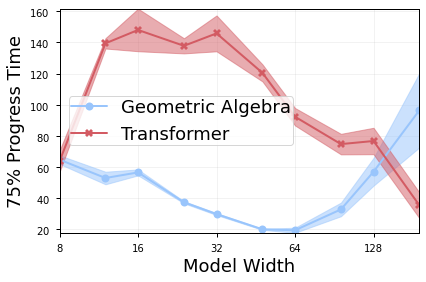

In [7]:
thresh = .75

model_series = collections.defaultdict(DataSeries)

pdb_cache_dir = '/tmp'
for (fname, desc) in conn.execute(
    'select fname, workflow_description from data where dataset = "PDBCoarseGrained"'):
    desc = json.loads(desc)

    model_index = [i for (i, stage) in enumerate(desc['stages']) if 'PDBInverseCoarseGrain' in stage['type']][0]
    model_type = desc['stages'][model_index]['type']
    model_width = desc['stages'][model_index]['arguments']['n_dim']

    cache_index = [i for (i, stage) in enumerate(desc['stages']) if stage['type'] == 'PDBCache'][0]
    desc['stages'][cache_index]['arguments']['cache_directory'] = pdb_cache_dir

    train_index = [i for (i, stage) in enumerate(desc['stages']) if stage['type'].endswith('Train')][0]
    steps = desc['stages'][train_index]['arguments']['generator_train_steps']
    desc['stages'] = desc['stages'][:train_index]

    with keras_gtar.Trajectory(fname, 'r') as traj:
        for (index, vals) in traj.handle.recordsNamed('val_loss'):
            worst, best = vals[0], np.min(vals)
            thresh_val = thresh*best + (1 - thresh)*worst
            indices = np.where(vals < thresh_val)[0]
            model_series[model_type].add(model_width, np.min(indices))

colors = pp.rcParams['axes.prop_cycle'].by_key()['color']
markers = itertools.cycle(['o-', 'X-'])
model_types = list(sorted(model_series))
label_map = dict(PDBInverseCoarseGrainTransformer='Transformer',
                 PDBInverseCoarseGrain='Geometric Algebra')
for color, marker, model_type in zip(colors, markers, model_types):
    ds = model_series[model_type]
    mu, sigma = ds.mean, ds.stderr
    pp.fill_between(ds.x, mu - sigma, mu + sigma, color=color, alpha=.5)
    pp.plot(ds.x, ds.mean, marker, color=color, label=label_map[model_type], markersize=8)
pp.legend()
pp.xlabel('Model Width')
pp.gca().set_xscale('log')
pp.minorticks_off()
xticks = 2**np.arange(3, 9)
pp.xticks(xticks, xticks)
pp.xlim(min(ds.x), max(ds.x))
pp.ylabel('{:d}% Progress Time'.format(int(thresh*100)));
pp.savefig('/tmp/cg_progress_time.svg');

1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped recor

2022-02-28 00:39:20.236687: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped recor

2022-02-28 00:57:40.290133: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped recor

2022-02-28 01:07:50.340702: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


2022-02-28 01:11:00.135840: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


2022-02-28 01:13:00.160812: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


2022-02-28 01:13:57.269122: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-02-28 01:14:00.132414: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14
1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


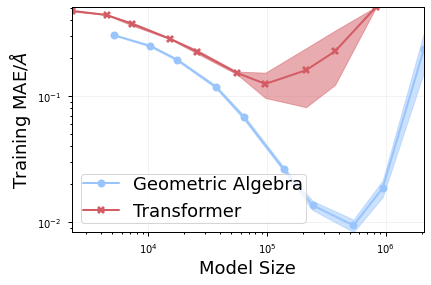

In [8]:
model_series = collections.defaultdict(DataSeries)

pdb_cache_dir = '/tmp'

try:
    if not 'force cache rebuild':
        raise NameError()
    get_model_errs()
except NameError:
    @functools.lru_cache
    def get_model_errs(rowid=None):
        if rowid is None:
            return

        for (fname, desc) in conn.execute(
            'select fname, workflow_description from data where rowid = ?', (rowid,)):

            desc = json.loads(desc)

            model_type = [stage['type'] for stage in desc['stages'] if 'PDBInverseCoarseGrain' in stage['type']][0]

            cache_index = [i for (i, stage) in enumerate(desc['stages']) if stage['type'] == 'PDBCache'][0]
            desc['stages'][cache_index]['arguments']['cache_directory'] = pdb_cache_dir

            train_index = [i for (i, stage) in enumerate(desc['stages']) if stage['type'].endswith('Train')][0]
            steps = desc['stages'][train_index]['arguments']['generator_train_steps']
            desc['stages'] = desc['stages'][:train_index]

            workflow = flowws.Workflow.from_JSON(desc)
            scope = workflow.run()

            try:
                with keras_gtar.Trajectory(fname, 'r') as traj:
                    model = traj.load()
            except Exception as e:
                print('skipping: {}'.format(e))
                return None, None, None

            model_size = sum([np.prod(v.shape) for v in model.trainable_weights])

            model_errs = []
            for (x, y) in itertools.islice(scope['train_generator'], steps):
                pred = model.predict_on_batch(x)
                err = np.abs((pred - y))*scope['y_scale']
                model_errs.append(err)

            return model_type, model_size, model_errs

for (fname, rowid) in conn.execute(
    'select fname, ROWID from data where dataset = "PDBCoarseGrained"'):
    (model_type, model_size, model_errs) = get_model_errs(rowid)

    if model_type is not None:
        model_series[model_type].add(model_size, np.mean(model_errs))

colors = pp.rcParams['axes.prop_cycle'].by_key()['color']
markers = itertools.cycle(['o-', 'X-'])
label_map = dict(PDBInverseCoarseGrainTransformer='Transformer',
                 PDBInverseCoarseGrain='Geometric Algebra')
for color, marker, (model_type, ds) in zip(colors, markers, sorted(model_series.items())):
    mu, sigma = ds.mean, ds.stderr
    pp.fill_between(ds.x, mu - sigma, mu + sigma, color=color, alpha=.5)
    pp.plot(ds.x, ds.mean, marker, color=color, label=label_map[model_type], markersize=8)
pp.legend()
pp.xlabel('Model Size')
pp.gca().set_xscale('log')
pp.gca().set_yscale('log')
pp.ylabel('Training MAE/$\\AA$');
pp.savefig('/tmp/cg_error_scaling.svg');

## MD17 validation error

In [9]:
import itertools
import json
import flowws

runs = []
for (rowid, wflow) in conn.execute('select ROWID, workflow_description from data where dataset LIKE "%MD17"'):
    for (molecules,) in conn.execute('select molecules from md17 where data_id = ?', (rowid,)):
        pass
    for (values,) in conn.execute('select arr_value from varyings where data_id = ? and name = ?', (rowid, 'val_mean_absolute_error')):
        pass

    w = flowws.Workflow.from_JSON(json.loads(wflow))
    args = w.stages[2].arguments

    dim = args['n_dim']
    blocks = args['n_blocks']
    residual = args['residual']
    nonlin = args['block_nonlinearity']

    opt = np.min(values)
    if np.isfinite(opt):
        runs.append([molecules, opt, dim, blocks, residual, nonlin, w])

runs.sort()

for (mol, bits) in itertools.groupby(runs, lambda x: x[0]):
    print(mol)
    for i, b in enumerate(bits):
        print(b[1:6])
        if i >= 4:
            break


Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused arguments found for stage: ['save_model', 'hash_size']
Unused a

MD17:aspirin
[12.063223838806152, 32, 6, True, True]
[12.56020450592041, 32, 6, True, True]
[13.545938491821289, 32, 6, True, True]
[13.83035659790039, 32, 6, True, True]
[15.086081504821777, 32, 6, True, True]
MD17:benzene
[6.4762187004089355, 32, 6, True, True]
[6.5197553634643555, 32, 6, True, True]
[6.590536117553711, 32, 6, True, True]
[6.7103095054626465, 32, 6, True, True]
[6.741830348968506, 32, 6, True, True]
MD17:ethanol
[4.14215087890625, 32, 6, True, True]
[4.231337547302246, 32, 6, True, True]
[4.540034770965576, 32, 6, True, True]
[4.676665306091309, 32, 6, True, True]
[5.401256561279297, 32, 6, True, True]
MD17:malonaldehyde
[7.234607219696045, 32, 6, True, True]
[7.901865005493164, 32, 6, True, True]
[8.524330139160156, 32, 6, True, True]
[8.665929794311523, 32, 6, True, True]
[9.234832763671875, 32, 6, True, True]
MD17:naphthalene
[3.675591468811035, 32, 6, True, True]
[3.9067883491516113, 32, 6, True, True]
[4.200793266296387, 32, 6, True, True]
[4.225848197937012, 32

# Training times

These use approximate times-per-epoch to estimate how long training actually took, given the number of epochs used in training.

In [10]:
seconds_per_epoch = 7
epochs = []
for (rowid,) in conn.execute(
    'select rowid from data where dataset = "PyriodicDataset"'):
    for (vals,) in conn.execute('select arr_value from varyings where name = "loss" and data_id = ?', (rowid,)):
        epochs.append(len(vals))
print(np.mean(epochs)*seconds_per_epoch/60)

49.583333333333336


In [11]:
seconds_per_epoch = dict(
    benzene=3,
    uracil=3,
    naphthalene=7,
    aspirin=9,
    salicylic_acid=5,
    malonaldehyde=2,
    ethanol=2,
    toluene=4,
)
seconds_per_epoch['benzene,uracil,naphthalene,aspirin,salicylic_acid,malonaldehyde,ethanol,toluene'] = 71
seconds_per_epoch = {'MD17:{}'.format(k): v for (k, v) in seconds_per_epoch.items()}
epochs = collections.defaultdict(list)
for (rowid,) in conn.execute(
    'select rowid from data where dataset = "MD17"'):
    for (molecules,) in conn.execute('select molecules from md17 where data_id = ?', (rowid,)):
        pass
    for (vals,) in conn.execute('select arr_value from varyings where name = "loss" and data_id = ?', (rowid,)):
        epochs[molecules].append(len(vals))

for (name, epoch_counts) in sorted(epochs.items()):
    mu = np.mean(epoch_counts)*seconds_per_epoch[name]/60
    print(name, '{:.02f}'.format(mu))
    if ',' in name or mu > 60:
        print(name, '({:.02f} hours)'.format(mu/60))

MD17:aspirin 3120.36
MD17:aspirin (52.01 hours)
MD17:benzene 1401.66
MD17:benzene (23.36 hours)
MD17:ethanol 1254.87
MD17:ethanol (20.91 hours)
MD17:malonaldehyde 1087.10
MD17:malonaldehyde (18.12 hours)
MD17:naphthalene 5284.53
MD17:naphthalene (88.08 hours)
MD17:salicylic_acid 2359.50
MD17:salicylic_acid (39.33 hours)
MD17:toluene 2794.67
MD17:toluene (46.58 hours)
MD17:uracil 2020.65
MD17:uracil (33.68 hours)


In [12]:
seconds_per_epoch = 47
epochs = []
for (rowid,) in conn.execute(
    'select rowid from data where dataset = "PDBCoarseGrained" AND workflow_description NOT LIKE "%PDBInverseCoarseGrainTransformer%"'):
    for (vals,) in conn.execute('select arr_value from varyings where name = "loss" and data_id = ?', (rowid,)):
        epochs.append(len(vals))
print(np.mean(epochs)*seconds_per_epoch/60/60, 'hours')

8.72085 hours


# Evaluation times

In [13]:
import timeit

In [14]:
rates = []

for (fname, desc) in conn.execute(
    'select fname, workflow_description from data where dataset = "PyriodicDataset"'):

    desc = json.loads(desc)
    train_index = [i for (i, stage) in enumerate(desc['stages']) if stage['type'].endswith('Train')][0]
    batch_size = max(1, desc['stages'][train_index]['arguments']['batch_size']//4)
    desc['stages'] = desc['stages'][:train_index]

    workflow = flowws.Workflow.from_JSON(desc)
    scope = workflow.run()

    with keras_gtar.Trajectory(fname, 'r') as traj:
        model = traj.load()

    stmt = "model.predict(scope['x_test'], batch_size=batch_size, verbose=0)"
    t = timeit.timeit(stmt, setup=stmt, number=3, globals=globals())
    rates.append(t/len(scope['x_test'][0])/3)

print(rates)
print(np.mean(rates), np.std(rates)/np.sqrt(len(rates)), np.min(rates))

1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
[0.00015691096928234665, 0.0001197113979607189, 0.00013954592292333162, 0.0001608271420456118, 0.00016455252835019874]
0.00014830959211244155 7.454298973258313e-06 0.0001197113979607189


In [15]:
iterator = itertools.groupby(conn.execute('select * from md17 order by molecules'), lambda x: x[1])

md17_location = '/tmp'

rates = collections.defaultdict(list)

for (mols, selection) in iterator:
    for (rowid, _) in selection:
        for (fname, desc) in conn.execute(
            'select fname, workflow_description from data where rowid = ?', (rowid,)):

            desc = json.loads(desc)
            train_index = [i for (i, stage) in enumerate(desc['stages']) if stage['type'].endswith('Train')][0]
            batch_size = max(1, desc['stages'][train_index]['arguments']['batch_size']//4)
            desc['stages'] = desc['stages'][:train_index]

            dset_index = [i for (i, stage) in enumerate(desc['stages']) if stage['type'].endswith('MD17')][0]
            desc['stages'][dset_index]['arguments']['cache_dir'] = md17_location

            workflow = flowws.Workflow.from_JSON(desc)
            scope = workflow.run()

            with keras_gtar.Trajectory(fname, 'r') as traj:
                model = traj.load()

            stmt = "model.predict(scope['x_test'], batch_size=batch_size, verbose=0)"
            t = timeit.timeit(stmt, setup=stmt, number=3, globals=globals())
            rates[mols].append(t/len(scope['x_test'][0])/3)

for (m, vals) in sorted(rates.items()):
    print(m)
    print(vals)
    print(np.mean(vals), np.std(vals)/np.sqrt(len(vals)), np.min(vals))


1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
1 Physic

In [ ]:
pdb_cache_dir = '/tmp'

model_times = collections.defaultdict(list)

for (fname, desc, rowid) in conn.execute(
    'select fname, workflow_description, ROWID from data where dataset = "PDBCoarseGrained"'):
    desc = json.loads(desc)

    model_index = [i for (i, stage) in enumerate(desc['stages']) if 'PDBInverseCoarseGrain' in stage['type']][0]
    model_type = desc['stages'][model_index]['type']
    model_width = desc['stages'][model_index]['arguments']['n_dim']

    cache_index = [i for (i, stage) in enumerate(desc['stages']) if stage['type'] == 'PDBCache'][0]
    desc['stages'][cache_index]['arguments']['cache_directory'] = pdb_cache_dir

    train_index = [i for (i, stage) in enumerate(desc['stages']) if stage['type'].endswith('Train')][0]
    steps = desc['stages'][train_index]['arguments']['generator_train_steps']
    desc['stages'] = desc['stages'][:train_index]

    workflow = flowws.Workflow.from_JSON(desc)
    scope = workflow.run()

    key = (model_type, model_width)

    with keras_gtar.Trajectory(fname, 'r') as traj:
        model = traj.load()

    stmt = "model.predict(scope['train_generator'], verbose=0, steps=steps, use_multiprocessing=False, workers=0)"
    t = timeit.timeit(stmt, setup=stmt.replace('=steps', '=16'), number=3, globals=globals())
    denominator = steps*len(next(scope['train_generator'])[0][0])*3
    model_times[key].append(t/denominator)

for (k, vals) in sorted(model_times.items()):
    print(k)
    print(vals)
    print(np.mean(vals), np.std(vals)/np.sqrt(len(vals)), np.min(vals))


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


2022-02-28 02:24:34.813170: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/final_attention/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


2022-02-28 02:25:49.398642: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/final_attention/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


2022-02-28 02:26:57.227285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/final_attention/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


2022-02-28 02:28:05.799477: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/final_attention/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


2022-02-28 02:29:12.315469: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/final_attention/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


2022-02-28 02:30:20.452013: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/final_attention/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


2022-02-28 02:31:32.276496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/final_attention/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


2022-02-28 02:32:37.498997: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/final_attention/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


2022-02-28 02:33:48.313880: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/final_attention/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1 Physical GPUs, 1 Logical GPUs
19 final records
0 skipped records
Max number of atoms in a residue: 14


2022-02-28 02:35:05.553199: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/final_attention/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
